In [1]:
import pandas as pd
import talib
import numpy as np
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit
import iisignature
from tqdm import tqdm  # For progress bar
from features import construct_features
from signature_feature import create_signature_features 
from sklearn.preprocessing import StandardScaler
from resample import resample


In [2]:
eth_df = pd.read_csv('ETHUSDC-1m-2years.csv') 

In [3]:
eth_df['timestamp'] = pd.to_datetime(eth_df['timestamp'],dayfirst=True )
eth_df.set_index('timestamp', inplace=True)

In [4]:
eth_df = resample(eth_df)

In [5]:
eth_df

,close,open,high,low,volume,quote_asset_volume,taker_buy_base_volume,taker_buy_quote_volume,number_of_trades
timestamp,,,,,,,,,
2024-01-01 00:00:00,2295.74,2281.65,2295.80,2281.08,169.0123,3.870329e+05,124.5675,2.852305e+05,317
2024-01-01 00:15:00,2289.75,2295.55,2296.08,2288.28,150.1775,3.443548e+05,83.3018,1.910073e+05,261
2024-01-01 00:30:00,2292.54,2290.21,2294.07,2287.75,94.0602,2.153777e+05,55.2550,1.265054e+05,160
2024-01-01 00:45:00,2295.23,2292.71,2296.44,2291.67,98.8650,2.268397e+05,61.9785,1.421942e+05,172
2024-01-01 01:00:00,2296.17,2294.68,2296.94,2292.02,82.2080,1.885529e+05,59.7542,1.370508e+05,192
...,...,...,...,...,...,...,...,...,...
2025-09-30 22:45:00,4142.15,4145.00,4149.88,4132.43,961.0545,3.979510e+06,454.6494,1.882738e+06,5629
2025-09-30 23:00:00,4130.00,4142.16,4142.95,4118.80,2723.1519,1.123745e+07,918.1660,3.788027e+06,6523
2025-09-30 23:15:00,4139.54,4130.05,4142.60,4126.52,960.7879,3.973824e+06,522.8142,2.162205e+06,3339


In [6]:
new_df = construct_features(eth_df)
sig_features = create_signature_features(eth_df, window_size=100, level=2)

new_df = pd.concat([new_df, sig_features], axis=1)

Computing Rolling Signatures (Window: 100, Level: 2)...


100%|██████████| 61244/61244 [00:00<00:00, 224841.25it/s]


In [7]:
new_df = new_df.drop(columns=['Sig_0','Sig_2']) #drop constant features see report for explanation  

In [8]:
print(new_df.head())
new_df.columns.to_list()

                     open_lag_1  high_lag_1  low_lag_1  close_lag_1  \
timestamp                                                             
2024-01-01 00:00:00         NaN         NaN        NaN          NaN   
2024-01-01 00:15:00     2281.65     2295.80    2281.08      2295.74   
2024-01-01 00:30:00     2295.55     2296.08    2288.28      2289.75   
2024-01-01 00:45:00     2290.21     2294.07    2287.75      2292.54   
2024-01-01 01:00:00     2292.71     2296.44    2291.67      2295.23   

                     number_of_trades_lag_1  quote_asset_volume_lag_1  \
timestamp                                                               
2024-01-01 00:00:00                     NaN                       NaN   
2024-01-01 00:15:00                   317.0             387032.895068   
2024-01-01 00:30:00                   261.0             344354.762305   
2024-01-01 00:45:00                   160.0             215377.668459   
2024-01-01 01:00:00                   172.0             226839.7

['open_lag_1',
 'high_lag_1',
 'low_lag_1',
 'close_lag_1',
 'number_of_trades_lag_1',
 'quote_asset_volume_lag_1',
 'taker_buy_quote_volume_lag_1',
 'volume_lag_1',
 'HminusL',
 'return_lag_1',
 'return_lag_2',
 'return_lag_3',
 'return_lag_4',
 'return_lag_5',
 'SMA',
 'correlation_sma_close',
 'sum3',
 'sum5',
 'sum3-sum5',
 'target',
 'RSI9',
 'RSI14',
 'RSI9Smaller20',
 'RSI14Smaller20',
 'RSI9Bigger80',
 'MACD1',
 'MACD2',
 'MACD3',
 'roc9',
 'roc14',
 'ewa',
 'mom5',
 'WilliamR',
 'doubleEMA',
 'ATR5',
 'ATR10',
 'aroon_stoch_k',
 'aroon_stoch_d',
 'Sig_1',
 'Sig_3',
 'Sig_4',
 'Sig_5']

In [9]:
new_df.dropna(inplace=True)

In [10]:
Y = new_df['target']
X = new_df.drop(columns = 'target')

In [11]:
from scipy import stats

corr = pd.DataFrame()
corr.index = X.columns
for col in X.columns:
    st = stats.pearsonr(X[col], Y)
    corr.loc[col, 'corr'] = st.statistic
    corr.loc[col, 'pvalue'] = st.pvalue

corr.sort_values(key = lambda x: np.abs(x), by='corr', ascending=False)

,corr,pvalue
RSI9,-0.071272,8.509518e-70
RSI14,-0.066579,4.014603e-61
WilliamR,0.065260,8.599903e-59
sum3,-0.053294,9.001582e-40
mom5,-0.052364,1.870321e-38
sum5,-0.052156,3.666574e-38
MACD3,-0.048929,8.713191e-34
roc9,-0.045682,1.158653e-29
MACD1,-0.041564,7.803130e-25
return_lag_1,-0.041225,1.857512e-24


In [12]:
length = len(eth_df)
print(length)

61344


In [13]:
n1 = int(len(X) * 0.8)
n2 = int(len(X) * 0.9)

X_train, y_train = X[:n1], Y[:n1]
X_eval, y_eval = X[n1:n2], Y[n1:n2]
X_test, y_test = X[n2:], Y[n2:]

In [14]:
sum(y_test==0)/len(y_test)

0.4948571428571429

In [15]:
params={'learning_rate': 0.001,
        'max_depth': 8,
        'n_jobs': -1,
        'early_stopping_round':500,
        'random_state':42,
        'n_estimators':10000,
        'max_depth':64,
        #'objective': 'accuracy',
        'feature_fraction':0.5,
        #'reg_alpha':100,
        #'max_depth':-1,
        #'reg_lambda':1,
        #'lambda_l2':3.0,        
        #'lambda_l1':0.5,
        'bagging_fraction':0.5,
        'bagging_freq':2,
        'min_data_in_leaf': 20
        #'boosting_type':''
        }
LGBMmodel=LGBMClassifier(**params)
        
LGBMmodel.fit(X_train, y_train, eval_set=[(X_eval, y_eval)])

y_pred = LGBMmodel.predict(X_test)
        
print("LGBM Accuracy: ",accuracy_score(y_test, y_pred))

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 24669, number of neg

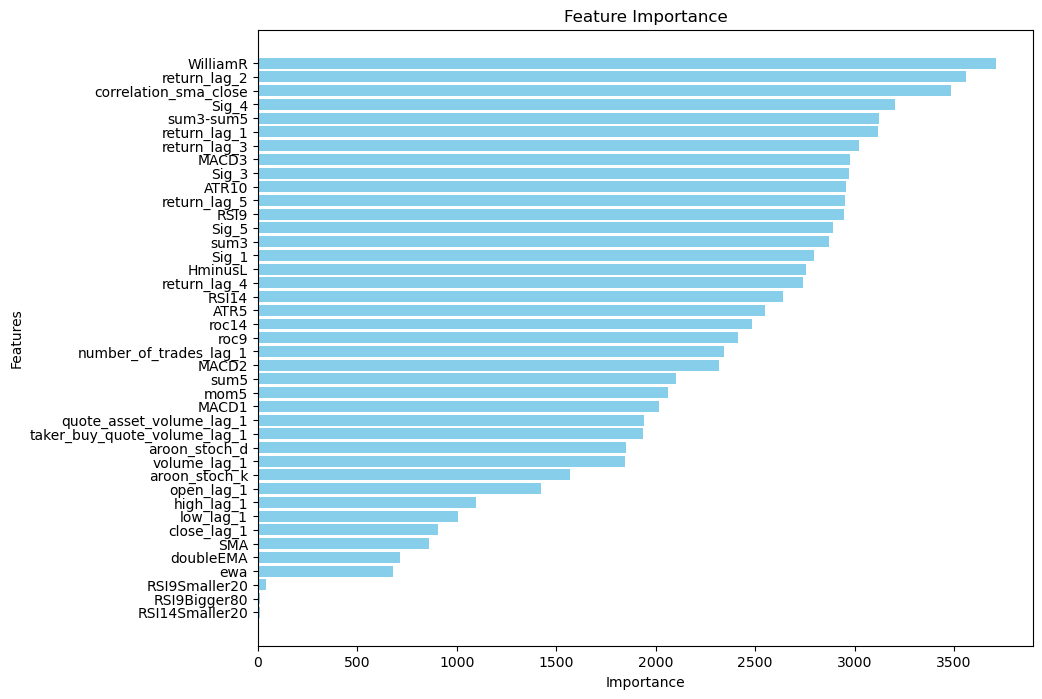

In [16]:
import matplotlib.pyplot as plt

# Extract feature importance from the LightGBM model
feature_importances = LGBMmodel.feature_importances_
features = X.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

## Neural Network

In [17]:
from pytorch_tabnet.tab_model import TabNetRegressor, TabNetClassifier
import torch

/opt/anaconda3/envs/mlkaggle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_eval_scaled = scaler.transform(X_eval)

model= TabNetClassifier(optimizer_fn=torch.optim.Adam,
                scheduler_params={"step_size":10, 
                                    "gamma":0.9},
                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                )
model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_eval_scaled, y_eval)],
    eval_name=['train', 'validation'],
    eval_metric=['accuracy'],
    max_epochs=500, patience=80,
    batch_size=512, virtual_batch_size=512,
    drop_last=False
)            

X_test_scaled = scaler.transform(X_test)
y_pred = model.predict(X_test_scaled)
score = accuracy_score(y_test, y_pred)    
print(f"TabNet Score: {score:0.3f}")
#print(f"TabNet OOF Score: {accuracy_score(Y, oof)}")


/opt/anaconda3/envs/mlkaggle/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71171 | train_accuracy: 0.51981 | validation_accuracy: 0.51404 |  0:00:05s
epoch 1  | loss: 0.69301 | train_accuracy: 0.5246  | validation_accuracy: 0.524   |  0:00:10s
epoch 2  | loss: 0.69296 | train_accuracy: 0.52373 | validation_accuracy: 0.52596 |  0:00:14s
epoch 3  | loss: 0.69248 | train_accuracy: 0.52587 | validation_accuracy: 0.5196  |  0:00:19s
epoch 4  | loss: 0.6925  | train_accuracy: 0.5262  | validation_accuracy: 0.51061 |  0:00:24s
epoch 5  | loss: 0.69191 | train_accuracy: 0.5305  | validation_accuracy: 0.5111  |  0:00:28s
epoch 6  | loss: 0.69192 | train_accuracy: 0.53063 | validation_accuracy: 0.51796 |  0:00:33s
epoch 7  | loss: 0.69179 | train_accuracy: 0.5276  | validation_accuracy: 0.52368 |  0:00:37s
epoch 8  | loss: 0.69192 | train_accuracy: 0.53024 | validation_accuracy: 0.52237 |  0:00:42s
epoch 9  | loss: 0.69175 | train_accuracy: 0.52918 | validation_accuracy: 0.51911 |  0:00:46s
epoch 10 | loss: 0.69155 | train_accuracy: 0.53307 | validat

/opt/anaconda3/envs/mlkaggle/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet Score: 0.524


## Logistic Regression

In [19]:
n1 = int(len(X) * 0.9)

X_train, y_train = X[:n1], Y[:n1]
X_test, y_test = X[n1:], Y[n1:]

from sklearn.linear_model import LogisticRegressionCV
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = LogisticRegressionCV(cv=5, random_state=42, max_iter=5000)#), penalty='l1', solver='liblinear')

print("Training model and tuning C...")
clf.fit(X_train_scaled, y_train)

optimal_c = clf.C_[0]

print("-" * 30)
print(f"Optimal C value found: {optimal_c:.4f}")
print("-" * 30)

y_pred = clf.predict(X_test_scaled)
print(f"Test Set Accuracy: {accuracy_score(y_test, y_pred):.4f}")



Training model and tuning C...
------------------------------
Optimal C value found: 0.0001
------------------------------
Test Set Accuracy: 0.5293
